In [149]:
##THIS IS AN ATTEMPT TO CREATE THE VAE BY USING THE PERCEPTUAL LOSS USING VGG16

In [1]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms

class UnderWaterImages(Dataset):
    def __init__(self,folder,transforms=None):
        self.raw = os.path.join(folder,'Raw')
        self.ref = os.path.join(folder,'Reference')
        self.image_names = os.listdir(self.raw)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self,idx):
        img_name = self.image_names[idx]
        raw_path = os.path.join(self.raw,img_name)
        ref_path = os.path.join(self.ref,img_name)
        raw_img = Image.open(raw_path).convert('RGB')
        ref_img = Image.open(ref_path).convert('RGB')

        if self.transforms:
            raw_img = self.transforms(raw_img)
            ref_img = self.transforms(ref_img)
        return raw_img,ref_img

In [2]:
import torchvision.models as models
import torchvision.transforms as T
weights = models.VGG16_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [3]:
train_dataset = UnderWaterImages('/kaggle/input/denoisingunderwaterimages/Train',transforms)

In [4]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def denormalize(img):
    #CXHXW
    img = std[:,None,None]*img + mean[:,None,None]
    img = img.clamp(0,1)
    return img.permute(1,2,0)

In [5]:
from torch.utils.data import random_split, DataLoader
dataset_size = len(train_dataset)
val_size = int(0.2 * dataset_size)   
train_size = dataset_size - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [147]:
test_dataset = UnderWaterImages('/kaggle/input/denoisingunderwaterimages/Test',transforms)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [6]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1), #112x112
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1), #56x56
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1), #28,28
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1), #14x14
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(),
            nn.Conv2d(256,256,kernel_size=4,stride=2,padding=1), #7x7
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(),            
            nn.Flatten()
        )

        self.fc1 = nn.Linear(256*7*7,1024)
        self.fc2 = nn.Linear(256*7*7,1024)

    def forward(self,x):
        features = self.features(x)
        # print(features)
        mu = self.fc1(features)
        # print(mu)
        log_vars = self.fc2(features)
        # print(log_vars)
        return mu,log_vars

In [7]:
def reparameterize(mu,log_vars):
    std = torch.exp(0.5*log_vars)
    eps = torch.randn_like(std)
    z = mu + std*eps
    return z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1024,256*7*7)
        self.features = nn.Sequential(
            nn.Upsample(scale_factor=2),  #14x14
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),  #28x28
            nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),       
            nn.Upsample(scale_factor=2),  #56x56
            nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),   
            nn.Upsample(scale_factor=2),  #112x112
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),   
            nn.Upsample(scale_factor=2),  #224x224
            nn.Conv2d(32,3,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),               
        )

    def forward(self,z):
        z = self.fc1(z)
        x = z.reshape(-1,256,7,7)
        out = self.features(x)
        return out

In [9]:
import torchvision.models as models

weights = models.VGG16_Weights.IMAGENET1K_V1
vgg16 = models.vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]  


In [10]:
import torch.nn.functional as F

def saveActivations(name,activations):
    def hook(module,input,output):
        activations[name] = output
    return hook
    
def outputs(img):
    activations = {}
    h1 = vgg16.features[1].register_forward_hook(saveActivations('relu1_1',activations))
    h2 = vgg16.features[6].register_forward_hook(saveActivations('relu2_1',activations))
    h3 = vgg16.features[11].register_forward_hook(saveActivations('relu3_1',activations))
    _ = vgg16.features[:12](img)
    h1.remove()
    h2.remove()
    h3.remove()
    return activations
    
def reconLoss(original,reconstructed):
    
    with torch.no_grad():
        activation_original = outputs(original)
        
    activation_reconstructed = outputs(reconstructed)
    
    total_loss = 0.0
    for v1,v2 in zip(activation_original.values(),activation_reconstructed.values()):
        total_loss+= F.mse_loss(v1,v2)

    total_loss /=3
    return total_loss 

In [11]:
def KLdivergence(mu,log_vars):
    kl = 0.5*torch.sum(1+log_vars-mu.pow(2)-log_vars.exp(),dim=1)
    kl = -kl.mean()
    return kl

In [126]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=0.0002)

def train(epoch,alpha=1,beta=1):
    #function to train a single epoch
    epoch_totalLoss = 0.0
    epoch_klLoss = 0.0
    epoch_reconLoss = 0.0
    pbar = tqdm(train_loader,desc=f"Train_epoch {epoch}/{epochs}")
    for raw,ref in pbar:
        raw = raw.to(device)
        ref = ref.to(device)
        
        mu,log_vars = encoder(raw)
        # print(f"mu: {mu}")
        # print(f"log_vars: {log_vars}")
        z = reparameterize(mu,log_vars)
        out = decoder(z)
        
        recon_loss = beta*reconLoss(ref,out)
        kl_loss = alpha*KLdivergence(mu,log_vars)
        total_loss = kl_loss + recon_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_norm=1.0)
        optimizer.step()        
        
        epoch_totalLoss+= total_loss.item()
        epoch_klLoss+=kl_loss.item()
        epoch_reconLoss+=recon_loss.item()

        
    epoch_reconLoss /= len(train_loader)
    epoch_klLoss /= len(train_loader)
    epoch_totalLoss /= len(train_loader)
    return epoch_reconLoss,epoch_klLoss,epoch_totalLoss

In [123]:
epochs = 100
# alpha = 1
beta = 2
patience = 15

In [95]:
def valLoss(alpha=1,beta=1):
    totalLoss = 0.0
    klLoss = 0.0
    reconloss = 0.0
    for raw,ref in val_loader:
        encoder.eval()
        decoder.eval()
        raw = raw.to(device)
        ref = ref.to(device)
        
        mu,log_vars = encoder(raw)
        z = reparameterize(mu,log_vars)
        out = decoder(z)
        
        recon_loss = beta*reconLoss(ref,out)
        kl_loss = alpha*KLdivergence(mu,log_vars)
        total_loss = kl_loss + recon_loss   
        
        totalLoss+= total_loss.item()
        klLoss+=kl_loss.item()
        reconloss+=recon_loss.item()

        
    reconloss /= len(val_loader)
    klLoss /= len(val_loader)
    totalLoss /= len(val_loader)
    return reconloss,klLoss,totalLoss

In [96]:
kl_anneal_start_epoch = 30
kl_anneal_end_epoch = 50

In [97]:
def getOutput(img_batch):
    img_batch = img_batch.to(device)
    encoder.eval()
    decoder.eval() 
    mu,log_vars = encoder(img_batch)
    z = reparameterize(mu,log_vars)
    out = decoder(z)
    return out

In [98]:
#fixed images to track
raw_batch, ref_batch = next(iter(val_loader))
track_raw = raw_batch[0]
track_ref = ref_batch[0] 

In [104]:
img = track_raw[None,:,:,:]

In [105]:
img.shape

torch.Size([1, 3, 224, 224])

In [125]:
os.makedirs("reconstructions",exist_ok=True)
def saveTrack(epoch,og,recon,tar):
    fig,axes = plt.subplots(1,3,figsize=(10,5))
    axes[0].set_title("Noisy")
    axes[1].set_title("Reconstructed")
    axes[2].set_title("Target")
    og = og.to('cpu')
    recon = recon.detach().cpu()
    tar = tar.to('cpu')
    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")
    axes[0].imshow(denormalize(og))
    axes[1].imshow(denormalize(recon))
    axes[2].imshow(denormalize(tar))  
    plt.tight_layout()
    plt.savefig(f"reconstructions/{epoch}.png")
    plt.close()

In [127]:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1,gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
count = 0
best_valLoss = 1e9
alpha_max=1
# alpha = 1

for param in vgg16.parameters():
    param.requires_grad = False
    
vgg16.eval()
vgg16.to(device)

save_epoch = [1,10,20,30,40,50,60,70,80,90,100]

for epoch in range(1,epochs+1):
    encoder.train()
    decoder.train()
   
    if epoch<kl_anneal_start_epoch or epoch>kl_anneal_end_epoch:
        alpha = 0
    else:
        alpha = alpha_max*(epoch-kl_anneal_start_epoch)/(kl_anneal_end_epoch-kl_anneal_start_epoch)

    epoch_reconLoss,epoch_klLoss,epoch_totalLoss = train(epoch,alpha,beta)
    val_loss, _, _ = valLoss(alpha,beta)
    scheduler.step(val_loss)
    if val_loss < best_valLoss:
        torch.save(decoder.state_dict(),'decoder.pth')
        torch.save(encoder.state_dict(),'encoder.pth')
        best_valLoss = val_loss
        count = 0

    else: 
        count += 1
    
    print(f"epoch_reconLoss: {epoch_reconLoss:.4f} | epoch_klLoss: {epoch_klLoss:.4f} | epoch_totalLoss: {epoch_totalLoss:.4f} | totalval_loss: {val_loss:.4f}")

    if epoch in save_epoch:
        img = track_raw[None,:,:,:]
        out = getOutput(img).squeeze(0)
        saveTrack(epoch,track_raw,out,track_ref)
        
    if count==patience:
        break
    
    

Train_epoch 1/100: 100%|██████████| 18/18 [00:37<00:00,  2.11s/it]


epoch_reconLoss: 7.7944 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.7944 | totalval_loss: 7.9797


Train_epoch 2/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 7.6494 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.6494 | totalval_loss: 7.8203


Train_epoch 3/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.5853 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.5853 | totalval_loss: 7.7461


Train_epoch 4/100: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it]


epoch_reconLoss: 7.5565 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.5565 | totalval_loss: 7.7168


Train_epoch 5/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.5445 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.5445 | totalval_loss: 7.6952


Train_epoch 6/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.4924 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.4924 | totalval_loss: 7.6474


Train_epoch 7/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.4154 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.4154 | totalval_loss: 7.5820


Train_epoch 8/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.3796 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.3796 | totalval_loss: 7.5446


Train_epoch 9/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.3379 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.3379 | totalval_loss: 7.5221


Train_epoch 10/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 7.3050 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.3050 | totalval_loss: 7.5013


Train_epoch 11/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.2512 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.2512 | totalval_loss: 7.4905


Train_epoch 12/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 7.2395 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.2395 | totalval_loss: 7.4779


Train_epoch 13/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.2755 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.2755 | totalval_loss: 7.4639


Train_epoch 14/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 7.2193 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.2193 | totalval_loss: 7.4566


Train_epoch 15/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.2318 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.2318 | totalval_loss: 7.4675


Train_epoch 16/100: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it]


epoch_reconLoss: 7.1772 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.1772 | totalval_loss: 7.4471


Train_epoch 17/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.1274 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.1274 | totalval_loss: 7.4472


Train_epoch 18/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.1685 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.1685 | totalval_loss: 7.4280


Train_epoch 19/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.1456 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.1456 | totalval_loss: 7.4263


Train_epoch 20/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.1009 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.1009 | totalval_loss: 7.4276


Train_epoch 21/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.0519 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.0519 | totalval_loss: 7.4274


Train_epoch 22/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.0930 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.0930 | totalval_loss: 7.4211


Train_epoch 23/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.0475 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.0475 | totalval_loss: 7.4121


Train_epoch 24/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.0351 | epoch_klLoss: 0.0000 | epoch_totalLoss: 7.0351 | totalval_loss: 7.4170


Train_epoch 25/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 6.9960 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.9960 | totalval_loss: 7.4305


Train_epoch 26/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 6.9987 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.9987 | totalval_loss: 7.4166


Train_epoch 27/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 6.9247 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.9247 | totalval_loss: 7.4394


Train_epoch 28/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 6.8944 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8944 | totalval_loss: 7.4025


Train_epoch 29/100: 100%|██████████| 18/18 [00:37<00:00,  2.09s/it]


epoch_reconLoss: 6.8541 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8541 | totalval_loss: 7.4067


Train_epoch 30/100: 100%|██████████| 18/18 [00:37<00:00,  2.09s/it]


epoch_reconLoss: 6.8242 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8242 | totalval_loss: 7.4078


Train_epoch 31/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.6925 | epoch_klLoss: 105.6482 | epoch_totalLoss: 113.3407 | totalval_loss: 8.0527


Train_epoch 32/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.9393 | epoch_klLoss: 3.9144 | epoch_totalLoss: 11.8537 | totalval_loss: 8.1203


Train_epoch 33/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 7.9861 | epoch_klLoss: 1.2856 | epoch_totalLoss: 9.2717 | totalval_loss: 8.1087


Train_epoch 34/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.9370 | epoch_klLoss: 0.8010 | epoch_totalLoss: 8.7380 | totalval_loss: 8.0811


Train_epoch 35/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.8748 | epoch_klLoss: 0.5904 | epoch_totalLoss: 8.4652 | totalval_loss: 8.0517


Train_epoch 36/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.8511 | epoch_klLoss: 0.5517 | epoch_totalLoss: 8.4029 | totalval_loss: 8.0263


Train_epoch 37/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.8234 | epoch_klLoss: 0.4341 | epoch_totalLoss: 8.2575 | totalval_loss: 8.0175


Train_epoch 38/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.8372 | epoch_klLoss: 0.4356 | epoch_totalLoss: 8.2729 | totalval_loss: 8.0094


Train_epoch 39/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.8446 | epoch_klLoss: 0.4125 | epoch_totalLoss: 8.2571 | totalval_loss: 7.9964


Train_epoch 40/100: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it]


epoch_reconLoss: 7.8091 | epoch_klLoss: 0.4115 | epoch_totalLoss: 8.2206 | totalval_loss: 7.9836


Train_epoch 41/100: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it]


epoch_reconLoss: 7.8215 | epoch_klLoss: 0.3628 | epoch_totalLoss: 8.1843 | totalval_loss: 7.9783


Train_epoch 42/100: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it]


epoch_reconLoss: 7.7922 | epoch_klLoss: 0.3848 | epoch_totalLoss: 8.1770 | totalval_loss: 7.9710


Train_epoch 43/100: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it]


epoch_reconLoss: 7.7790 | epoch_klLoss: 0.4246 | epoch_totalLoss: 8.2036 | totalval_loss: 7.9665


In [128]:
def getOutput(img_batch):
    img_batch = img_batch.to(device)
    encoder.eval()
    decoder.eval() 
    mu,log_vars = encoder(img_batch)
    z = reparameterize(mu,log_vars)
    out = decoder(z)
    return out

In [129]:
encoder.load_state_dict(torch.load("/kaggle/working/encoder.pth"))
decoder.load_state_dict(torch.load("/kaggle/working/decoder.pth"))

<All keys matched successfully>

In [134]:
import matplotlib.pyplot as plt

def visualizeResults(loader):
    raw_batch, ref_batch = next(iter(loader))
    mini_raw_batch = raw_batch[:3]
    mini_ref_batch = ref_batch[:3]
    fig,axes = plt.subplots(3,3,figsize=(12,6))
    axes[0, 0].set_title("Noisy")
    axes[0, 1].set_title("Reconstructed")
    axes[0, 2].set_title("Target")

    out = getOutput(mini_raw_batch).detach().cpu()

    for i in range(3):
        axes[i,0].axis("off")
        axes[i,1].axis("off")
        axes[i,2].axis("off")
        axes[i,0].imshow(denormalize(mini_raw_batch[i]))
        axes[i,1].imshow(denormalize(out[i]))
        axes[i,2].imshow(denormalize(mini_ref_batch[i]))
    
    plt.tight_layout()
    plt.savefig("reconstructions/")

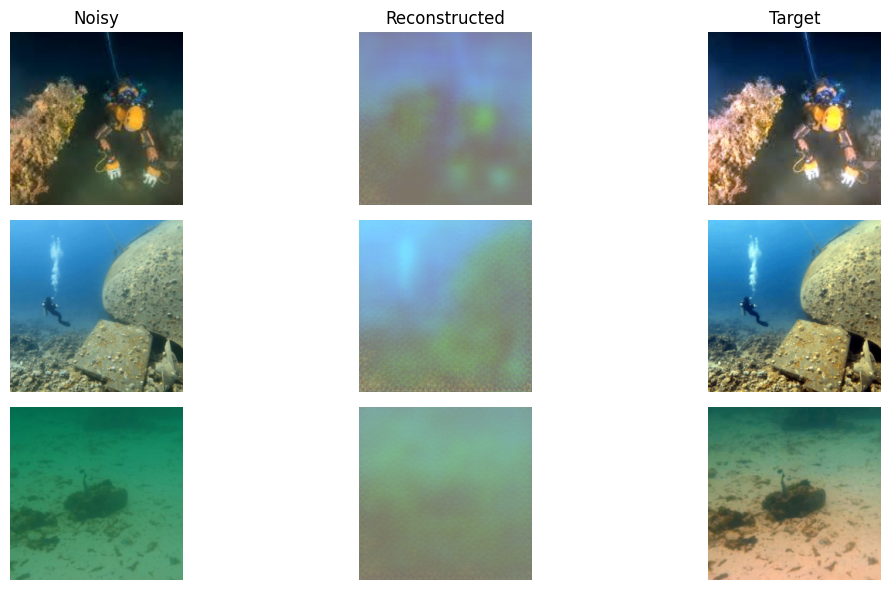

In [135]:
visualizeResults(train_loader)

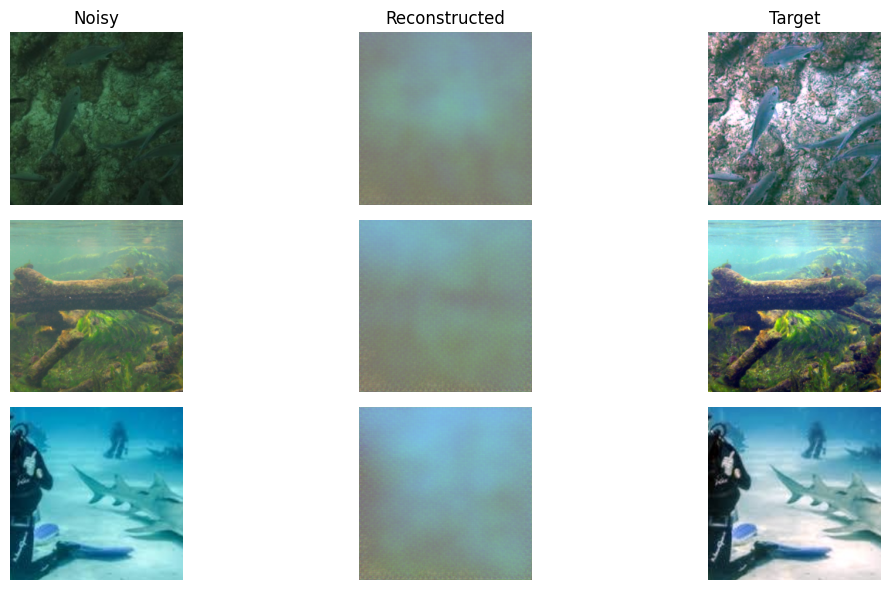

In [136]:
visualizeResults(val_loader)

**finetuning stage**

In [137]:
epochs = 100
# alpha = 1
beta = 2
patience = 15

In [138]:
kl_anneal_start_epoch = 5
kl_anneal_end_epoch = 25

In [139]:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1,gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
count = 0
best_valLoss = 1e9
alpha_max=0.1
# alpha = 1

for param in vgg16.parameters():
    param.requires_grad = False
    
vgg16.eval()
vgg16.to(device)

save_epoch = [1,10,20,30,40,50,60,70,80,90,100]

for epoch in range(1,epochs+1):
    encoder.train()
    decoder.train()
   
    if epoch<kl_anneal_start_epoch or epoch>kl_anneal_end_epoch:
        alpha = 0
    else:
        alpha = alpha_max*(epoch-kl_anneal_start_epoch)/(kl_anneal_end_epoch-kl_anneal_start_epoch)

    epoch_reconLoss,epoch_klLoss,epoch_totalLoss = train(epoch,alpha,beta)
    val_loss, _, _ = valLoss(alpha,beta)
    scheduler.step(val_loss)
    if val_loss < best_valLoss:
        torch.save(decoder.state_dict(),'decoder.pth')
        torch.save(encoder.state_dict(),'encoder.pth')
        best_valLoss = val_loss
        count = 0

    else: 
        count += 1
    
    print(f"epoch_reconLoss: {epoch_reconLoss:.4f} | epoch_klLoss: {epoch_klLoss:.4f} | epoch_totalLoss: {epoch_totalLoss:.4f} | totalval_loss: {val_loss:.4f}")

    if epoch in save_epoch:
        img = track_raw[None,:,:,:]
        out = getOutput(img).squeeze(0)
        saveTrack(epoch,track_raw,out,track_ref)
        
    if count==patience:
        break
    
    

Train_epoch 1/100: 100%|██████████| 18/18 [00:38<00:00,  2.13s/it]


epoch_reconLoss: 6.8308 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8308 | totalval_loss: 7.3924


Train_epoch 2/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 6.8555 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8555 | totalval_loss: 7.3934


Train_epoch 3/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 6.8573 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8573 | totalval_loss: 7.3933


Train_epoch 4/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 6.8242 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8242 | totalval_loss: 7.3932


Train_epoch 5/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 6.8076 | epoch_klLoss: 0.0000 | epoch_totalLoss: 6.8076 | totalval_loss: 7.3945


Train_epoch 6/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 6.8132 | epoch_klLoss: 44.5691 | epoch_totalLoss: 51.3823 | totalval_loss: 7.4521


Train_epoch 7/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 6.9785 | epoch_klLoss: 64.7614 | epoch_totalLoss: 71.7399 | totalval_loss: 7.6198


Train_epoch 8/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.2411 | epoch_klLoss: 70.0664 | epoch_totalLoss: 77.3075 | totalval_loss: 7.7668


Train_epoch 9/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.4295 | epoch_klLoss: 66.6834 | epoch_totalLoss: 74.1130 | totalval_loss: 7.9087


Train_epoch 10/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.5852 | epoch_klLoss: 64.6215 | epoch_totalLoss: 72.2066 | totalval_loss: 7.9814


Train_epoch 11/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 7.7237 | epoch_klLoss: 64.8960 | epoch_totalLoss: 72.6197 | totalval_loss: 8.0382


Train_epoch 12/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.8055 | epoch_klLoss: 62.5324 | epoch_totalLoss: 70.3379 | totalval_loss: 8.0780


Train_epoch 13/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.8316 | epoch_klLoss: 58.2787 | epoch_totalLoss: 66.1104 | totalval_loss: 8.1023


Train_epoch 14/100: 100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


epoch_reconLoss: 7.8537 | epoch_klLoss: 55.0190 | epoch_totalLoss: 62.8726 | totalval_loss: 8.1096


Train_epoch 15/100: 100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


epoch_reconLoss: 7.8699 | epoch_klLoss: 53.8673 | epoch_totalLoss: 61.7372 | totalval_loss: 8.1146


Train_epoch 16/100: 100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


epoch_reconLoss: 7.8907 | epoch_klLoss: 51.8719 | epoch_totalLoss: 59.7626 | totalval_loss: 8.1186


In [140]:
encoder.load_state_dict(torch.load("/kaggle/working/encoder.pth"))
decoder.load_state_dict(torch.load("/kaggle/working/decoder.pth"))

<All keys matched successfully>

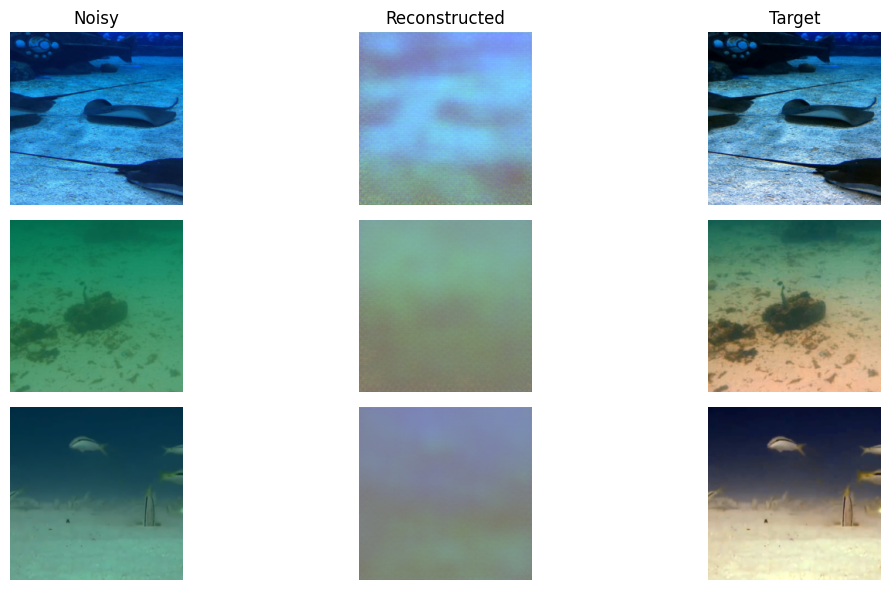

In [141]:
visualizeResults(train_loader)

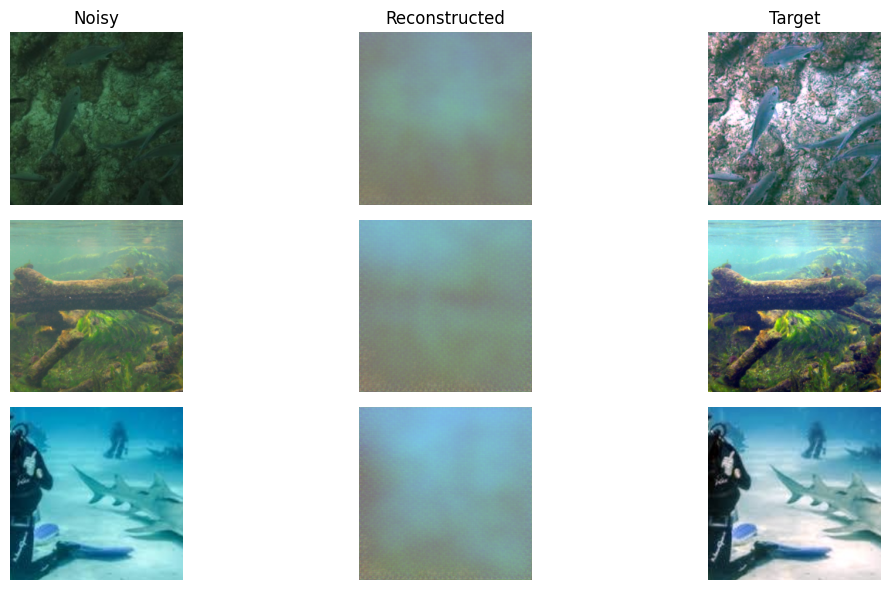

In [142]:
visualizeResults(val_loader)

In [144]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

def compute_metrics_batch(original_batch, reconstructed_batch):
    batch_size = original_batch.size(0)
    original_batch = original_batch.detach().cpu().permute(0,2,3,1).numpy().astype(np.float32)
    reconstructed_batch = reconstructed_batch.detach().cpu().permute(0,2,3,1).numpy().astype(np.float32)

    mse_list = []
    psnr_list = []
    ssim_list = []

    for i in range(batch_size):
        orig = original_batch[i]
        recon = reconstructed_batch[i]

        mse_list.append(mean_squared_error(orig, recon))
        psnr_list.append(peak_signal_noise_ratio(orig, recon, data_range=1))
        ssim_list.append(structural_similarity(orig, recon, channel_axis=-1, data_range=1))

    mse_avg = np.mean(mse_list)
    psnr_avg = np.mean(psnr_list)
    ssim_avg = np.mean(ssim_list)

    return mse_avg, psnr_avg, ssim_avg

In [176]:
def denormalizeBatch(batch):
    for i in range(batch.size(0)):
        img = batch[i]
        img = img.detach().cpu()
        d_img = denormalize(img)
        batch[i] = d_img.permute(2,0,1)
    return batch

In [177]:
mse_total = 0.0
psnr_total = 0.0
ssim_total = 0.0
num_batches = 0

with torch.no_grad():
    for (batch_raw,batch_ref) in test_loader:
        batch_raw, batch_ref = batch_raw.to(device), batch_ref.to('cpu')
        batch_recon = getOutput(batch_raw).detach().cpu()   
        
        mse, psnr, ssim = compute_metrics_batch(denormalizeBatch(batch_ref), denormalizeBatch(batch_recon))

        mse_total += mse
        psnr_total += psnr
        ssim_total += ssim
        num_batches += 1

mse_avg = mse_total / num_batches
psnr_avg = psnr_total / num_batches
ssim_avg = ssim_total / num_batches

print(f"Test MSE: {mse_avg:.4f}")
print(f"Test PSNR: {psnr_avg:.2f} dB")
print(f"Test SSIM: {ssim_avg:.4f}")

Test MSE: 0.0661
Test PSNR: 12.19 dB
Test SSIM: 0.2653
